# Predicting Newsletter Subscription from Player Age in a Minecraft Research Server


# Introduction:

In this course, we complete a full data science project from beginning to end and communicate the entire workflow in a single Jupyter Notebook. The notebook combines code cells and Markdown cells: code cells are used to download the data, wrangle and clean it in a reproducible way, perform exploratory analysis and fit predictive models; Markdown cells narrate each step, explain the question being asked, motivate our methodological choices, and summarize the conclusions. By the end of the project, the notebook functions both as an analysis script and as a written report that another reader can run and understand from top to bottom.

The data for this project come from a research group in Computer Science at the University of British Columbia that operates a custom Minecraft server. Players can join this server, explore a shared world, and interact with various in-game tasks. As part of a research study on human behaviour in video games, the group collects information about who joins the server and how they play. Running such a study is logistically challenging: the team must recruit enough players to obtain useful data, but they must also ensure that they have enough technical resources—such as server capacity and software licenses—to support those players. Understanding which kinds of players are most engaged with the project is therefore practically important.

One simple signal of engagement is whether a player subscribes to a game-related email newsletter. Players who subscribe are likely to be interested in future updates and may be more inclined to return to the server, participate in follow-up experiments, or respond to surveys. From the research group’s perspective, being able to predict which players are likely to subscribe could help them target recruitment efforts (for example, by tailoring messages to specific age groups) and plan resources more efficiently.

In this report we focus on the following predictive question:

> **Can we predict whether a player subscribes to the newsletter based on their age?**

To address this question, we use the `players.csv` data set provided by the research team. This file is a player-level summary: it contains one row for each unique player who joined the Minecraft server. In total, there are 196 players and 7 variables:

- `experience`: the player’s self-reported Minecraft experience level (e.g., “beginner”, “intermediate”, “expert”);
- `hashedEmail`: an anonymized identifier derived from the player’s email address, used to link records without revealing personal information;
- `name`: the player’s in-game name;
- `gender`: the player’s self-reported gender;
- `played_hours`: the total number of hours the player has spent on the server;
- `Age`: the player’s age in years (numeric);
- `subscribe`: a logical indicator of whether the player subscribed to the newsletter (`TRUE` for subscribed, `FALSE` for not subscribed).

For our main analysis we focus on `Age` as the explanatory variable and `subscribe` as the binary response variable. We begin by cleaning the `players.csv` data: we remove players with missing age or subscription information and convert `subscribe` into a factor with levels *No* and *Yes* for ease of visualization and modelling. This yields a cleaned data set of 194 players. We then compute summary statistics and create exploratory visualizations to understand how newsletter subscription rates vary across age groups. Finally, guided by the methods introduced in this class, we fit and evaluate a K-nearest neighbours classification model that uses age to predict whether a player subscribes to the newsletter, and we discuss what the results suggest about the role of age in player engagement on the Minecraft server.


# Methods: 

All of the analysis was carried out in R using the `tidyverse` and `tidymodels` packages inside a Jupyter Notebook, so that the workflow is fully reproducible.

We began by loading the main packages needed for the project: `tidyverse` for data wrangling and visualization, `tidymodels` for modelling, and `ggplot2` for plotting. We then loaded the `players.csv` data directly from a GitHub URL using `read_csv`. Loading the data from a URL ensures that anyone running the notebook will read exactly the same dataset without needing any local files. After reading the data we confirmed that there were 196 players and 7 variables, including `Age` (numeric), `subscribe` (logical), and several additional demographic and experience variables.

Next, we created a cleaned player-level dataset that contained only the variables relevant for this project: `Age` and `subscribe`. Using `dplyr::filter`, we removed any rows where age or subscription status was missing (`is.na(Age)` or `is.na(subscribe)`), because our model cannot be trained on players without age information or a known subscription outcome. We then used `mutate` to convert `subscribe` from a logical variable (`TRUE` / `FALSE`) into a factor with two levels, labelled *No* and *Yes*. This factor format is convenient for both plotting and classification models. We also computed basic summary statistics to better understand the cleaned dataset, such as the number of players, the mean and standard deviation of age, and the counts of subscribers and non-subscribers.

To explore how newsletter subscription varies with age, we created an age-group variable and a corresponding visualization. Using `mutate` and `cut`, we grouped players into 5-year age bands from 5 to 60 years (for example, 5–10, 10–15, and so on). We then used `ggplot` with `geom_bar(position = "fill")` to produce a stacked bar chart that shows, for each age group, the proportion of players who subscribed and did not subscribe. The y-axis was formatted as percentages using `scale_y_continuous(labels = scales::percent)`, and we added informative axis labels and a descriptive title. This plot (Figure 1) helps visualize whether younger and older players differ in their subscription behaviour.

For the modelling part of the analysis, we framed our problem as a binary classification task, where the goal is to predict `subscribe` (Yes/No) from `Age`. We adopted the K-nearest neighbours (K-NN) classification approach implemented in `tidymodels`, following the workflow introduced in the course. First, we split the cleaned data into a training set and a test set using `initial_split(players_age, prop = 0.8, strata = subscribe)`. The `prop = 0.8` argument assigns approximately 80% of the players to the training set and 20% to the test set, while `strata = subscribe` ensures that both sets have similar proportions of subscribers and non-subscribers. We then used `training()` and `testing()` to extract the `players_train` and `players_test` datasets from this split.

On the training data, we built a preprocessing recipe using `recipes::recipe`. The recipe specified `subscribe ~ Age` to indicate that `Age` is our predictor and `subscribe` is the response. We then added a normalization step, `step_normalize(all_predictors())`, which centers and scales the age variable so that it has mean 0 and standard deviation 1. Normalizing predictors is important for K-NN because the algorithm is based on distances between observations; without normalization, predictors on larger scales could dominate the distance calculations.

We then defined a K-NN model specification using `nearest_neighbor(weight_func = "rectangular", neighbors = tune())`, and set the engine to `"kknn"` and the mode to `"classification"` with `set_engine("kknn")` and `set_mode("classification")`. The `neighbors = tune()` argument indicates that the number of neighbours, \(k\), is a tuning parameter that we will select using cross-validation. To do this, we created a 5-fold cross-validation object with `vfold_cv(players_train, v = 5, strata = subscribe)`, which splits the training data into five folds while preserving the subscription class proportions in each fold.

Next, we combined the recipe and model specification into a single workflow using `workflow() |> add_recipe(subscribe_recipe) |> add_model(knn_spec)`. We also created a grid of candidate \(k\) values (odd integers between 1 and 51) using `tibble(neighbors = seq(1, 51, by = 2))`. Using `tune_grid`, we trained and evaluated K-NN models with each value of \(k\) across the cross-validation folds, and collected the results with `collect_metrics()`. This produced a table (`knn_results`) containing, for each \(k\), the mean cross-validated accuracy and related statistics. We then filtered this table to keep only the rows where `.metric == "accuracy"`, and used `slice_max(mean, n = 1)` to select the value of \(k\) with the highest mean accuracy. This best-performing value of \(k\), stored in `best_k`, was carried forward to the final model.

With the tuned value of \(k\) in hand, we defined a final K-NN model specification with `neighbors = best_k` and refitted the workflow on the full training set using `fit()`. To evaluate the model’s performance on unseen data, we used `predict()` on `players_test` to obtain both the predicted classes (`.pred_class`) and the predicted probabilities (`.pred_No` and `.pred_Yes`) for each player, and stored these together with the true `subscribe` values and `Age` in a single `test_pred` data frame. Finally, we computed the overall test accuracy using `metrics(test_pred, truth = subscribe, estimate = .pred_class)` and examined the confusion matrix using `conf_mat(test_pred, truth = subscribe, estimate = .pred_class)`. These summary measures allow us to assess how well age alone can predict newsletter subscription, and they form the basis for the results and discussion presented in the next section.



# Code:

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Loading data into R by using link from github so it is reproducible:

In [2]:
players <- read_csv("https://raw.githubusercontent.com/calentynes/dsci_group_project/refs/heads/master/players.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
players_age <- players |> 
  filter(!is.na(Age),
         !is.na(subscribe)) |>
  mutate(
    subscribe = factor(subscribe,
                       levels = c(FALSE, TRUE),
                       labels = c("No", "Yes"))
  )


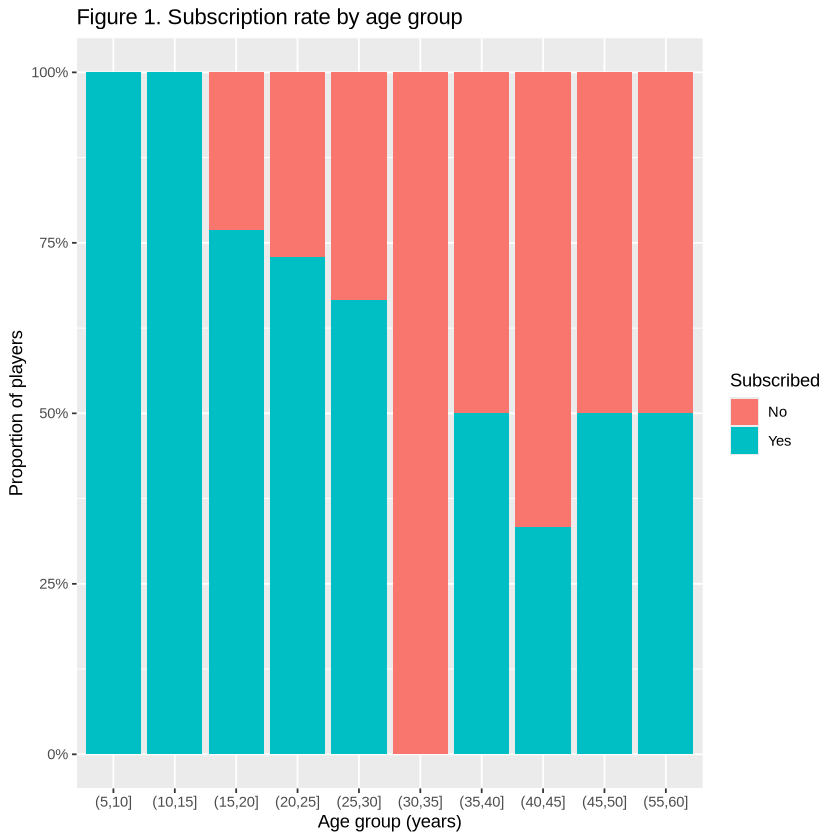

In [4]:
p_age <- players_age |>
  mutate(age_group = cut(Age,
                         breaks = seq(5, 60, by = 5),
                         right = TRUE)) |>
  ggplot(aes(x = age_group, fill = subscribe)) +
  geom_bar(position = "fill") +
  scale_y_continuous(labels = scales::percent) +
  labs(
    title = "Figure 1. Subscription rate by age group",
    x = "Age group (years)",
    y = "Proportion of players",
    fill = "Subscribed"
  )

p_age

In [5]:
set.seed(123)

players_split <- initial_split(players_age, prop = 0.8, strata = subscribe)
players_train <- training(players_split)
players_test  <- testing(players_split)

subscribe_recipe <- recipe(subscribe ~ Age, data = players_train) |>
  step_normalize(all_predictors())

knn_spec <- nearest_neighbor(
    weight_func = "rectangular",
    neighbors   = tune()
  ) |>
  set_engine("kknn") |>
  set_mode("classification")

players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

players_wflow <- workflow() |>
  add_recipe(subscribe_recipe) |>
  add_model(knn_spec)

grid_k <- tibble(neighbors = seq(1, 51, by = 2))

set.seed(123)
knn_results <- players_wflow |>
  tune_grid(resamples = players_vfold,
            grid      = grid_k) |>
  collect_metrics()


In [6]:
best_k <- knn_results |>
  filter(.metric == "accuracy") |>
  slice_max(mean, n = 1) |>
  pull(neighbors)

best_k

[1] 31

In [7]:
final_knn_spec <- nearest_neighbor(
    weight_func = "rectangular",
    neighbors   = best_k
  ) |>
  set_engine("kknn") |>
  set_mode("classification")

final_wflow <- workflow() |>
  add_recipe(subscribe_recipe) |>
  add_model(final_knn_spec)

final_fit <- final_wflow |>
  fit(data = players_train)

test_pred <- predict(final_fit, players_test, type = "prob") |>
  bind_cols(
    predict(final_fit, players_test),
    players_test |> select(subscribe, Age)
  )

head(test_pred)


.pred_No,.pred_Yes,.pred_class,subscribe,Age
<dbl>,<dbl>,<fct>,<fct>,<dbl>
0.3548387,0.6451613,Yes,Yes,17
0.3548387,0.6451613,Yes,No,17
0.1935484,0.8064516,Yes,No,21
0.3548387,0.6451613,Yes,Yes,17
0.4516129,0.5483871,Yes,Yes,58
0.5161290,0.4838710,No,No,18


In [8]:
test_metrics <- metrics(test_pred,
                        truth   = subscribe,
                        estimate = .pred_class) |>
  filter(.metric == "accuracy")
test_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.75


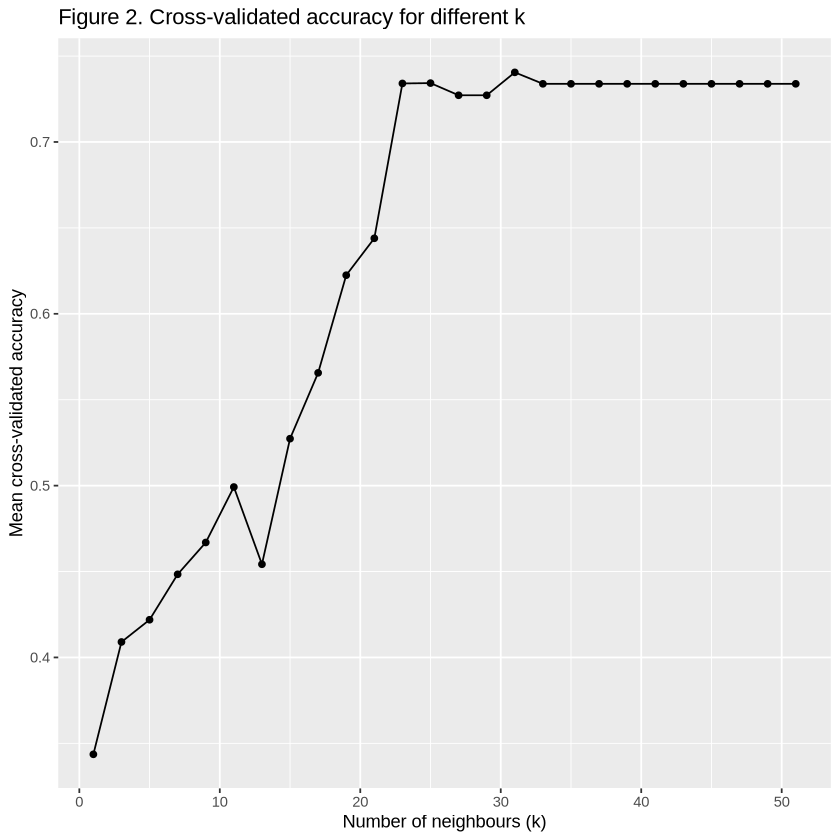

In [9]:
# Keep only rows for accuracy from the tuning results
knn_accuracy <- knn_results |>
  filter(.metric == "accuracy")

# Plot mean cross-validated accuracy against k
knn_accuracy_plot <- knn_accuracy |>
  ggplot(aes(x = neighbors, y = mean)) +
  geom_line() +
  geom_point() +
  labs(
    title = "Figure 2. Cross-validated accuracy for different k",
    x = "Number of neighbours (k)",
    y = "Mean cross-validated accuracy"
  )

knn_accuracy_plot

In [10]:
model_summary <- tibble(
  best_k = best_k,
  test_accuracy = test_metrics$`.estimate`
)

model_summary

best_k,test_accuracy
<dbl>,<dbl>
31,0.75


In [11]:
test_conf_mat <- conf_mat(
  data = test_pred,
  truth = subscribe,
  estimate = .pred_class
)

test_conf_mat

          Truth
Prediction No Yes
       No   1   0
       Yes 10  29

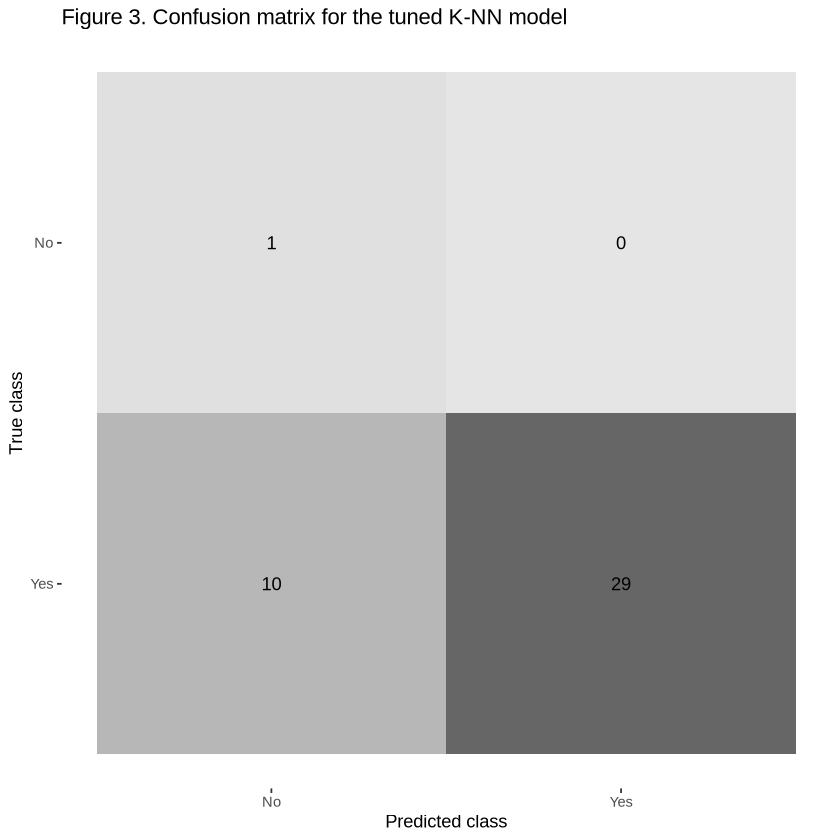

In [12]:
conf_mat_plot <- autoplot(test_conf_mat, type = "heatmap") +
  labs(
    title = "Figure 3. Confusion matrix for the tuned K-NN model",
    x = "Predicted class",
    y = "True class"
  )

conf_mat_plot

In [14]:
majority_class <- players_train |>
  count(subscribe) |>
  slice_max(n, n = 1, with_ties = FALSE) |>
  pull(subscribe)

majority_class


[1] Yes
Levels: No Yes

In [16]:

test_baseline <- players_test |>
  mutate(baseline_pred = majority_class)


baseline_metrics <- metrics(
  data = test_baseline,
  truth = subscribe,
  estimate = baseline_pred
) |>
  filter(.metric == "accuracy")

baseline_metrics


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.725


In [17]:
accuracy_comparison <- tibble(
  model = c("Baseline (majority class)", "K-NN with tuned k"),
  accuracy = c(
    baseline_metrics$`.estimate`,
    test_metrics$`.estimate`
  )
)

accuracy_comparison

model,accuracy
<chr>,<dbl>
Baseline (majority class),0.725
K-NN with tuned k,0.750



# Discussion:
- summarize what you found
- discuss whether this is what you expected to find
- discuss what impact could such findings have
- discuss what future questions could this lead to


# References

You may include references if necessary, as long as they all have a consistent citation style.